Epoch 1/15
898/898 [==============================] - 66s 71ms/step - loss: 1.6779 - accuracy: 0.3303 - val_loss: 1.5111 - val_accuracy: 0.4209
Epoch 2/15
898/898 [==============================] - 63s 70ms/step - loss: 1.4906 - accuracy: 0.4242 - val_loss: 1.4136 - val_accuracy: 0.4592
Epoch 3/15
898/898 [==============================] - 62s 69ms/step - loss: 1.4072 - accuracy: 0.4581 - val_loss: 1.3349 - val_accuracy: 0.4841
Epoch 4/15
898/898 [==============================] - 64s 71ms/step - loss: 1.3454 - accuracy: 0.4838 - val_loss: 1.3033 - val_accuracy: 0.4889
Epoch 5/15
898/898 [==============================] - 58s 64ms/step - loss: 1.2968 - accuracy: 0.5051 - val_loss: 1.2854 - val_accuracy: 0.5109
Epoch 6/15
898/898 [==============================] - 57s 64ms/step - loss: 1.2527 - accuracy: 0.5200 - val_loss: 1.2513 - val_accuracy: 0.5152
Epoch 7/15
898/898 [==============================] - 58s 64ms/step - loss: 1.2032 - accuracy: 0.5404 - val_loss: 1.2431 - val_accuracy:

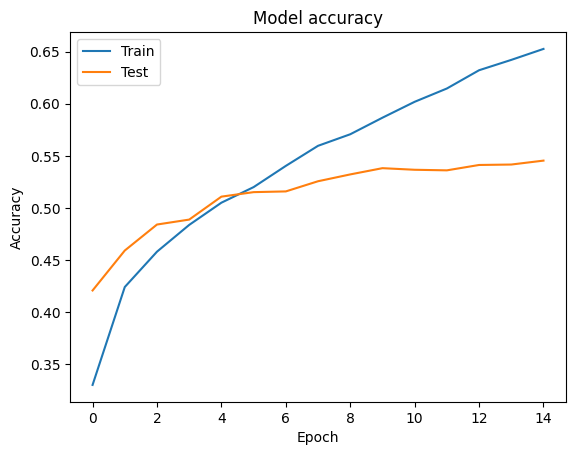

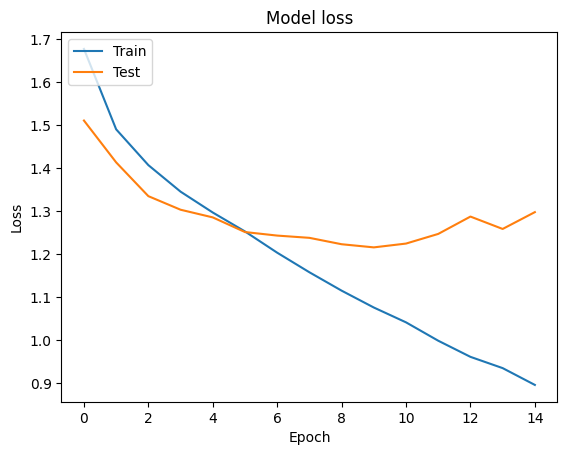

225/225 [==============================] - 4s 17ms/step - loss: 1.2977 - accuracy: 0.5454
Test Accuracy: 0.545416533946991


In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# Define the list of emotion categories
folder_path = r"C:\Users\HP\Downloads\archive"
Classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Function to load and preprocess the dataset
def load_dataset(folder_path):
    data = []
    labels = []

    for category in Classes:
        path = os.path.join(folder_path, category)
        class_num = Classes.index(category)

        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                img_arr = cv2.resize(img_arr, (48, 48))  # Resize images to 48x48
                data.append(img_arr)
                labels.append(class_num)
            except Exception as e:
                print(f"Error reading image: {os.path.join(path, img)}")
    data = np.array(data)
    labels = np.array(labels)

    return data, labels

# Load the training dataset
X_train, y_train = load_dataset(r"C:\Users\HP\Downloads\archive\train")

# Load the testing dataset
X_test, y_test = load_dataset(r"C:\Users\HP\Downloads\archive\test")

# Normalize pixel values to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

# Define the CNN model with only two convolutional layers
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(Classes), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with proper configuration
history = model.fit(X_train.reshape(-1, 48, 48, 1), y_train, epochs=15, batch_size=32, validation_data=(X_test.reshape(-1, 48, 48, 1), y_test))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(X_test.reshape(-1, 48, 48, 1), y_test)

print("Test Accuracy:", test_accuracy)


In [4]:
model.save('my_model_36.keras')

In [1]:
import cv2
import numpy as np
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model("my_model_36.keras")

# Load the pre-trained Haar Cascade face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Create a list of emotion labels
emotion_labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Load the image
image_path = r"C:\Users\HP\Downloads\lovepik-cute-beauty-fear-expression-picture_501769553.jpg" # Replace with your image file path
frame = cv2.imread(image_path)

# Convert the frame to grayscale
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Detect faces in the frame
faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5, minSize=(30, 30))

for (x, y, w, h) in faces:
    # Extract the face region
    face_roi = gray_frame[y:y + h, x:x + w]

    # Resize the face region to match the input size of the model
    resized_face = cv2.resize(face_roi, (48, 48))

    # Normalize the pixel values to be between 0 and 1
    normalized_face = resized_face / 255.0

    # Reshape the face to match the input shape expected by the model
    input_face = normalized_face.reshape(-1, 48, 48, 1)

    # Make a prediction using the trained model
    predictions = model.predict(input_face)

    # Get the index of the predicted emotion
    predicted_emotion_index = np.argmax(predictions)

    # Get the corresponding emotion label
    facial_expression = emotion_labels[predicted_emotion_index]

    # Define behaviors based on predicted emotions
    if facial_expression in ['happy', 'neutral']:
        behavior = 'Engaged'
    elif facial_expression in ['sad', 'angry']:
        behavior = 'Distressed'
    elif facial_expression == 'surprise':
        behavior = 'Curious'
    elif facial_expression == 'fear':
        behavior = 'Anxious'
    elif facial_expression == 'disgust':
        behavior = 'Uncomfortable'
    else:
        behavior = 'Uncertain'

    # Display the predicted emotion and behavior on the frame
    cv2.putText(frame, f"Emotion: {facial_expression}", (x, y + h + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 1, cv2.LINE_AA)
    cv2.putText(frame, f"Behavior: {behavior}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 1, cv2.LINE_AA)
  

    # Draw a rectangle around the detected face
    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the frame
cv2.imshow('Facial Expression Recognition', frame)
cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 1s 577ms/step


In [1]:
import cv2
import numpy as np
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model("my_model_36.keras")

# Load the pre-trained Haar Cascade face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Create a list of emotion labels
emotion_labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Open a connection to the video file"C:\Users\Poornima\Downloads\pexels-yan-krukov-8198503 (1080p).mp4"
video_path = r"C:\Users\HP\Downloads\gayathrivideo.mp4"  # Replace with your video file path
cap = cv2.VideoCapture(video_path)

while True:
    # Capture a single frame
    ret, frame = cap.read()

    if not ret:
        print("Video ended or cannot be opened.")
        break

    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        # Extract the face region
        face_roi = gray_frame[y:y + h, x:x + w]

        # Resize the face region to match the input size of the model
        resized_face = cv2.resize(face_roi, (48, 48))

        # Normalize the pixel values to be between 0 and 1
        normalized_face = resized_face / 255.0

        # Reshape the face to match the input shape expected by the model
        input_face = normalized_face.reshape(-1, 48, 48, 1)

        # Make a prediction using the trained model
        predictions = model.predict(input_face)

        # Get the index of the predicted emotion
        predicted_emotion_index = np.argmax(predictions)

        # Get the corresponding emotion label
        facial_expression = emotion_labels[predicted_emotion_index]

        # Define behaviors based on predicted emotions
        if facial_expression in ['happy', 'neutral']:
            behavior = 'Engaged'
        elif facial_expression in ['sad', 'angry']:
            behavior = 'Distressed'
        elif facial_expression == 'surprise':
            behavior = 'Curious'
        elif facial_expression == 'fear':
            behavior = 'Anxious'
        elif facial_expression == 'disgust':
            behavior = 'Uncomfortable'
        else:
            behavior = 'Uncertain' 
        

    
 

# Main loop to capture video frames and c
        # Display the predicted emotion and behavior on the frame
        cv2.putText(frame, f"Emotion: {facial_expression}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(frame, f"Behavior: {behavior}", (x, y + h + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)

        # Draw a rectangle around the detected face
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Display the frame
    cv2.imshow('Facial Expression Recognition', frame)

    # Break the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video file and close all windows
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 30ms/step
